<a href="https://colab.research.google.com/github/UniversalUser/SC_ModeloAgentes/blob/master/SC_Modelo_Agentes_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Checa que todas las dependencias esten instaladas en Google Colab
from __future__ import print_function
import importlib
from distutils.version import LooseVersion
required_packages = {'jupyter','numpy','matplotlib','ipywidgets','mesa','networkx'} # Nombres de paquetes de python disponibles para instalar con pip3
problem_packages = list()

for package in required_packages:
    package_org=package
    if '-' in package:
      package = package.split('-')
      package=package[0]
    try:
        p = importlib.import_module(package)
    except ImportError:
        problem_packages.append(package_org)
    
if len(problem_packages) is 0:
    print('Estan todos los paquetes.')
else:
    print('Los siguientes paquetes son requeridos y no estan instalados: ' + ', '.join(problem_packages))
    print('Se intentara instalarlos automaticamente')
    print('Puede usar el siguiente comando para instalar las dependencias: !pip3 install ElNombreDeLaDependencia')
    error = list()
    for package in problem_packages:
      try:
        print('Intentando instalar: '+package)
        !pip3 install $package;
      except ImportError:
        error.append(package)
      if len(error) is 0:
        print('Todos los paquetes fueron instalados.')
      else:
        print('No Todos los paquetes fueron instalados.')
        for i in error:
          print(i+' ')

Los siguientes paquetes son requeridos y no estan instalados: mesa
Se intentara instalarlos automaticamente
Puede usar el siguiente comando para instalar las dependencias: !pip3 install ElNombreDeLaDependencia
Intentando instalar: mesa
     |████████████████████████████████| 634kB 1.4MB/s 
     |████████████████████████████████| 40kB 5.5MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for mesa: filename=Mesa-0.8.6-cp36-none-any.whl size=646978 sha256=d70dd8327c0b67c36dad9df44540415c79a4cc0b1c4349e5136fddd0cb27ac6d
  Stored in directory: /root/.cache/pip/wheels/0b/e1/a9/8cb6a66246419d8268c559c551a6ea176481003d68168de011
Successfully built mesa
Todos los paquetes fueron instalados.


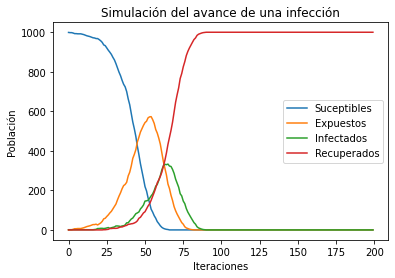

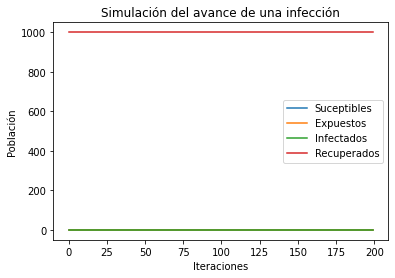

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from networkx import Graph
import networkx as nx
from mesa import Agent, Model
from mesa.time import BaseScheduler, RandomActivation
from mesa.space import MultiGrid
from random import gauss, random, sample, choice, choices
from timeit import timeit
from time import time

#Algunas constantes
SUCEPTIBLE = 0
EXPUESTO = 1
INFECTADO = 2
RECUPERADO = 3
salud_to_str={0:'Suceptible', 1:'Expuesto', 2:'Infectado', 3:'Recuperado'}
    

class Ciudad(Graph):
    """
    La ciudad es la que se encargará de generar los nodos que representen
    lugares de la ciudad como casas, centros comerciales, iglesias, o lo que sea.
    Tiene 4 métodos:
        * Generar los individuos
        * Crear los hogares
        * Hacer las conexiones entre los nodos casas y los lugares
        * Mover los individuos a nodos específicos
    La ciudad está representada como un grafo.
    """
    def __init__(self, model, agent_object, verbose = False):
        super().__init__()
        self.verbose = verbose
        self.agent_object = agent_object
        self.model = model
        self.p_matrimonio = 0.7
        self.promedio_hijos = 2
        self.casasids = []
        self.lugaresids = []
        self.agentes_a_asignar = []
    
    def generarindividuos(self):
        """
        Considerando el porcentaje de hombres y mujeres en la población, y la
        distribución de las edades en la población (considerando una distribución
        normal) se procede a generar la población.
        """
        porcentaje_hombres = 0.49
        individuos = []
        for i in range(self.model.num_ind):
            if random() <= porcentaje_hombres:
                sexo = 'h'
            else:
                sexo = 'm'
            edad = gauss(25,20)
            if edad < 0:
                edad = 0
            elif edad > 80:
                edad = 80
            individuos.append(self.agent_object(i,
                                        self.model, 
                                        edad,
                                        sexo)
                              )
        self.agentes_a_asignar = individuos
        return individuos
    
    def crear_hogares(self):
        """
        Consideranco la probabilidad de que en una casa exista un matrimonio,
        y el promedio de hijos menores a 23 años en cada casa, se asignan
        individuos a cada nodo hogar.
        Se consideran personas solteras con y sin hijos.
        """
        #Se generan las listas con cada tipo de individuos a repartir
        hombres = [ind for ind in self.agentes_a_asignar if ind.sexo == 'h' and ind.edad>=23]
        mujeres = [ind for ind in self.agentes_a_asignar if ind.sexo == 'm' and ind.edad>=23]
        hijos = [ind for ind in self.agentes_a_asignar if ind.edad < 23]
        if self.verbose: print(f'Cantidad de hombres {len(hombres)}, mujeres {len(mujeres)}, hijos {len(hijos)}')
        contador_nodos = 0
        while len(hombres)>0 or len(mujeres)>0:
            a_agregar = []
            matrimonio = random() < self.p_matrimonio
            ##Se asignan primero los jefes de familia (hombre y/o mujer)
            if len(hombres)*len(mujeres)>0 and matrimonio:
                a_agregar.append(hombres.pop())
                a_agregar.append(mujeres.pop())
            else:
                seleccion = sample([hombres, mujeres], 2)
                if len(seleccion[0])>0:
                    a_agregar.append(seleccion[0].pop())
                else:
                    a_agregar.append(seleccion[1].pop())
            
            ##Se asignan los hijos a cada casa
            n_hijos = abs(int(gauss(self.promedio_hijos, 0.5)))
            while len(hijos)>0 and n_hijos>0:
                a_agregar.append(hijos.pop())
                n_hijos-=1
            
            ##Se procede a crear el nodo correspondiente
            self.crear_nodo(contador_nodos, tipo = 'casa',
                            ocupantes = a_agregar)
            
            if self.verbose: print(f'En la casa {contador_nodos} hay {len(a_agregar)} personas. Matrimonio : {matrimonio}')
                
            self.casasids.append(contador_nodos)
            contador_nodos += 1
        
        ##Si sobran hijos, entonces se agregan al azar a todos los nodos
        while len(hijos) > 0:
            hijo = hijos.pop()
            idcasa = choice(list(self.nodes))
            espacio_casa = self.nodes[idcasa]['espacio']
            if self.verbose: print(f'Se agrega un hijo a la casa {idcasa}... ', end='')
            self.nodes[idcasa]['habitantes'].append(hijo.unique_id)
            #print('Espacios en casa', espacio_casa.empties)
            espacio_casa.place_agent(hijo, espacio_casa.empties[-1])
            hijo.casa_id = idcasa
            hijo.nodo_actual = idcasa
            if self.verbose: print('Agregado')
        
    def conectar_a_casas(self, nid):
        for i in list(self.nodes):
            if self.nodes[i]['tipo']=='casa':
                self.conectar_nodos(nid,i)
                
    def conectar_nodos(self, nodo1, nodo2):
        self.add_edge(nodo1, nodo2,
                      peso = 1)
            
    def crear_nodo(self,nodo_id, tipo, ocupantes = [], tamano = None):
        assert tipo in ['casa','tienda']
        if tipo == 'casa':
            assert len(ocupantes)>0, 'No hay ocupantes a asignar en la casa'
            if not tamano:
                tamano = len(ocupantes)//2+2
            habitantes = [ind.unique_id for ind in ocupantes]
        
        elif tipo == 'tienda':
            if not tamano:
                tamano = 20
            habitantes = []
        
        espacio = MultiGrid(width = tamano,
                            height = tamano,
                            torus = False)
        if tipo == 'casa':
            for i in ocupantes:
                i.casa_id = nodo_id
                i.nodo_actual = nodo_id
                espacio.place_agent(i, espacio.empties[-1])
        
        
        self.add_node(nodo_id, tipo = tipo,
                      habitantes = habitantes,
                      espacio = espacio)
        
    def mover_en_espacio(self, ind, nueva_pos):
        espacio = self.nodes[ind.nodo_actual]['espacio']
        espacio.move_agent(ind, nueva_pos)
    
    
    def mover_en_nodos(self, ind, nuevo_nodo_id):
        self.nodes[ind.nodo_actual]['espacio'].remove_agent(ind)
        self.nodes[nuevo_nodo_id]['espacio'].place_agent(ind, 
                                                        [0,0])
        ind.nodo_actual = nuevo_nodo_id
    
    def contactos(self, ind):
        x, y = ind.pos
        return self.nodes[ind.nodo_actual]['espacio'][x][y]

    def siguiente_paso_aleatorio(self, ind):
        x, y = ind.pos
        espacio = self.obtener_espacio(ind)
        paso_x, paso_y = choices([-1,0-1], k=2)
        nueva_x = x + paso_x
        nueva_y = y + paso_y
        nueva_x, nueva_y = self.ajustar_posicion((nueva_x, nueva_y),
                                                 espacio)
        espacio.move_agent(ind, (nueva_x, nueva_y))
        
    def ajustar_posicion(self, pos, espacio):
        """
        Recibe la posicón y la instancia del espacio a donde se desea ajustar
        """
        x, y = pos
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, espacio.width-1)
        y = min(y, espacio.height-1)
        return(x,y)

    def obtener_espacio(self, nodo_id_o_individuo):
        """
        Devuelve el espacio al que pertenece un individuo, o que contiene
        un nodo
        """
        if isinstance(nodo_id_o_individuo, Agent):
            return self.nodes[nodo_id_o_individuo.nodo_actual]['espacio']
        elif isinstance(nodo_id_o_individuo, int):
            return self.nodes[nodo_id_o_individuo]['espacio']
        else:
            raise ValueError(f'{nodo_id_o_individuo} no es un tipo válido')
        

class Individuo(Agent):
    
    def __init__(self, unique_id, model, edad, sexo):
        super().__init__(unique_id, model)
        self.ciudad = self.model.ciudad
        self.pos = None
        self.salud = SUCEPTIBLE
        self.sexo = sexo
        self.edad = edad
        self.pasos_infectado=0
        self.casa_id = None
        self.nodo_actual = None
        self.R0 = 6 # Índice de reproducción de la enfermedad entre individuos.
        self.pasos_para_infectar = 15
        self.pasos_para_recuperarse = 8
        self.asintomatico = False  # transmite, sin sintomas, no esta en cuarentena y su movilidad es regular. pend.
        self.en_cuarentena = 0 # 1: reduce movilidad, 2: aislamiento total.
        self.diagnosticado = False  # Se sabe que tiene la enfermedad y debe de estar en cuarentena. pend.
        self.politica_encasa = False
        self.politica_higiene = 0.0 # porcentaje de reduccion de la probalidad de contagio.
        self.mortalidad_apriori = 0.05 # pend.

    def step(self):
        if self.salud == SUCEPTIBLE or self.salud == EXPUESTO:

          if self.politica_encasa:
            habitantes=len(self.ciudad.nodes[self.casa_id]['habitantes'])
            moverse_entre_nodos = random() < (1/habitantes)
          else:
            moverse_entre_nodos = random() < 0.5

          if moverse_entre_nodos:
              if self.ciudad.nodes[self.nodo_actual]['tipo'] == 'casa':
                  self.ciudad.mover_en_nodos(self, 20000)
              else:
                  self.ciudad.mover_en_nodos(self, self.casa_id)
          else:
              self.ciudad.siguiente_paso_aleatorio(self)

        elif self.salud == INFECTADO:

          moverse_entre_nodos = random() < 0.25

          if moverse_entre_nodos and not self.en_cuarentena==2:
              if self.ciudad.nodes[self.nodo_actual]['tipo'] == 'casa':
                  self.ciudad.mover_en_nodos(self, 20000)
              else:
                  self.ciudad.mover_en_nodos(self, self.casa_id)
          else:
              self.ciudad.siguiente_paso_aleatorio(self)

        elif self.salud == RECUPERADO:

          moverse_entre_nodos = random() < 0.5

          if moverse_entre_nodos and not self.en_cuarentena==2:
              if self.ciudad.nodes[self.nodo_actual]['tipo'] == 'casa':
                  self.ciudad.mover_en_nodos(self, 20000)
              else:
                  self.ciudad.mover_en_nodos(self, self.casa_id)
          else:
              self.ciudad.siguiente_paso_aleatorio(self)

        self.interactuar()
        
        ## Se revisa la evolución de su salud
        if self.salud == EXPUESTO:
            self.pasos_infectado += 1
            if self.pasos_infectado > self.pasos_para_infectar:
                self.salud = INFECTADO
        elif self.salud == INFECTADO:
            self.pasos_infectado += 1
            if self.pasos_infectado>self.pasos_para_infectar + self.pasos_para_recuperarse:
                self.salud = RECUPERADO
    
    def interactuar(self):
        ## Se selecciona un número de agentes por contagiar de entre los que
        ## se encuentran en su mismo nodo, solamente si está infectado
        x, y = self.pos
        contactos = self.model.ciudad.nodes[self.nodo_actual]['espacio'][x][y]
        por_contagiar = self.R0//2
        prob_contagio = .8*(1-self.politica_higiene)
        if self.salud == INFECTADO and not self.en_cuarentena == 2:
            for a in sample(contactos, min(por_contagiar, len(contactos))):
                if a.salud == SUCEPTIBLE and random() < prob_contagio:
                    a.salud = EXPUESTO

class Modelo(Model):
    def __init__(self, N, city_object, agent_object):
        self.num_ind = N
        self.city_object = city_object
        self.agent_object = agent_object
        self.schedule = RandomActivation(self)
        self.crearciudad()
    
    def crearciudad(self):
        self.ciudad = self.city_object(self, self.agent_object)
        for ind in self.ciudad.generarindividuos():
            self.schedule.add(ind)
        
        #Se planta un infectado en la simulación
        self.schedule.agents[0].salud = INFECTADO
        
        #Se crean las casas distribuyendo los individuos
        self.ciudad.crear_hogares()
        
        #Se agrega una tienda a la ciudad y se conecta con todas las casas
        self.ciudad.crear_nodo(20000, tipo='tienda', tamano=2)
        self.ciudad.conectar_a_casas(20000)
    
    def step(self):
        self.schedule.step()
    
    def conteo(self):
        #Una función para contar los casos actuales en la ciudad
        datos = [0,0,0,0]
        for a in self.schedule.agents:
            datos[a.salud] += 1
        return datos

    def aplicar_politicas(self):
       for a in self.schedule.agents:
          a.politica_encasa= True

def test(Pob_ciudad):
    # Pob_Merida=957883
    modelo1 = Modelo(Pob_ciudad, Ciudad, Individuo)
    modelo2 = modelo1
    #nx.draw(m.ciudad)
    pasos=200
    historico=run_model(modelo1,pasos,0)
    historico2=run_model(modelo2,pasos,1)

    mostrar(historico)
    mostrar(historico2)

def run_model(mymodelo,pasos,politica):
    his = []
    for i in range(pasos):
        if i == 50 and politica:
          mymodelo.aplicar_politicas()
        mymodelo.step()
        conteo = mymodelo.conteo()
        his.append(conteo)
    return his

def test_pob_var(pob_final,pasos):
    tiempos=[]
    tiempos.append(0.0)
    poblacion=[]
    poblacion.append(0.0)
    for i in range(1,pasos+1,1):
      start_time = time()
      x=round(pob_final*(i/pasos))
      test(x)
      elapsed_time = time() - start_time
      tiempos.append(elapsed_time)
      poblacion.append(x)
      print("Población de %d con Tiempo de ejecución: %.4f segundos." % (x, elapsed_time))

    fig, ax = plt.subplots()
    ax.plot(np.array(poblacion),np.array(tiempos))
    ax.set_title('Tiempo de ejecución según incremento de la población')
    ax.set_xlabel('Población')
    ax.set_ylabel('Tiempo en Seg.')
    plt.show()

def mostrar(historico):
    historico = np.array(historico)
    fig, ax = plt.subplots()
    ax.plot(historico[:,0], label = 'Suceptibles')
    ax.plot(historico[:,1], label = 'Expuestos')
    ax.plot(historico[:,2], label = 'Infectados')
    ax.plot(historico[:,3], label = 'Recuperados')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Población')
    ax.set_title('Simulación del avance de una infección')
    ax.legend()
    plt.show()

if __name__=='__main__':
    Pob_ciudad=1000
    test(Pob_ciudad)
    # test_pob_var(Pob_ciudad,10)